## Predicting State of Charge (SOC) using featurization method

In [1]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
import warnings
from sklearn.exceptions import ConvergenceWarning
import sys, os
from tqdm import tqdm
from scipy import stats
import multiprocessing as mp
import seaborn as sns
from pathlib import Path

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
sys.path.append(str(Path().resolve().parent.parent))
from path_manager import TEST_DATA_NB, MISC_DIR

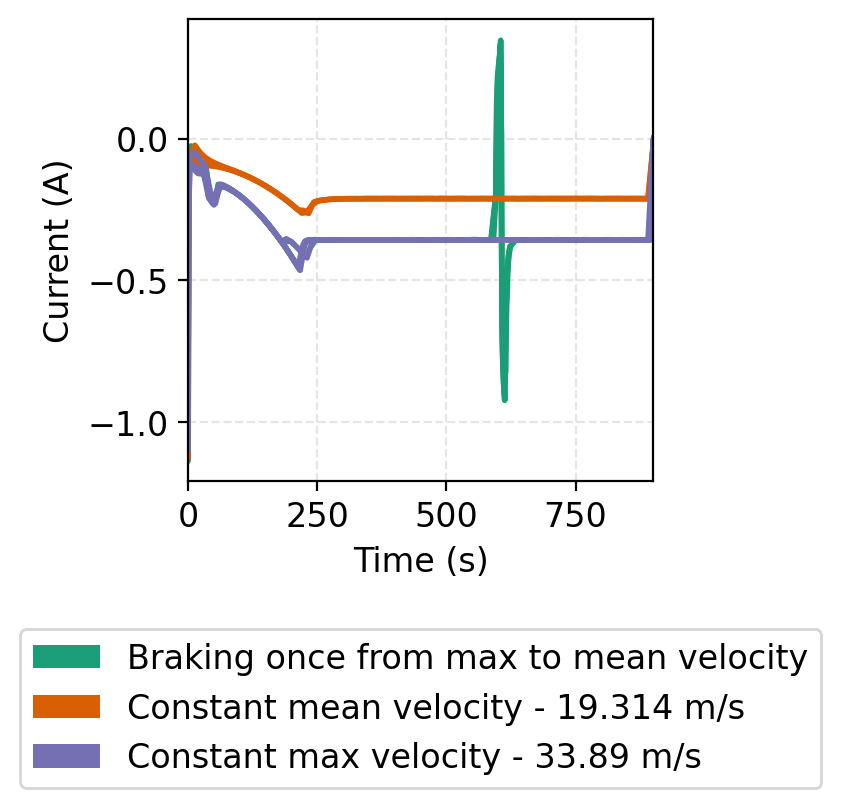

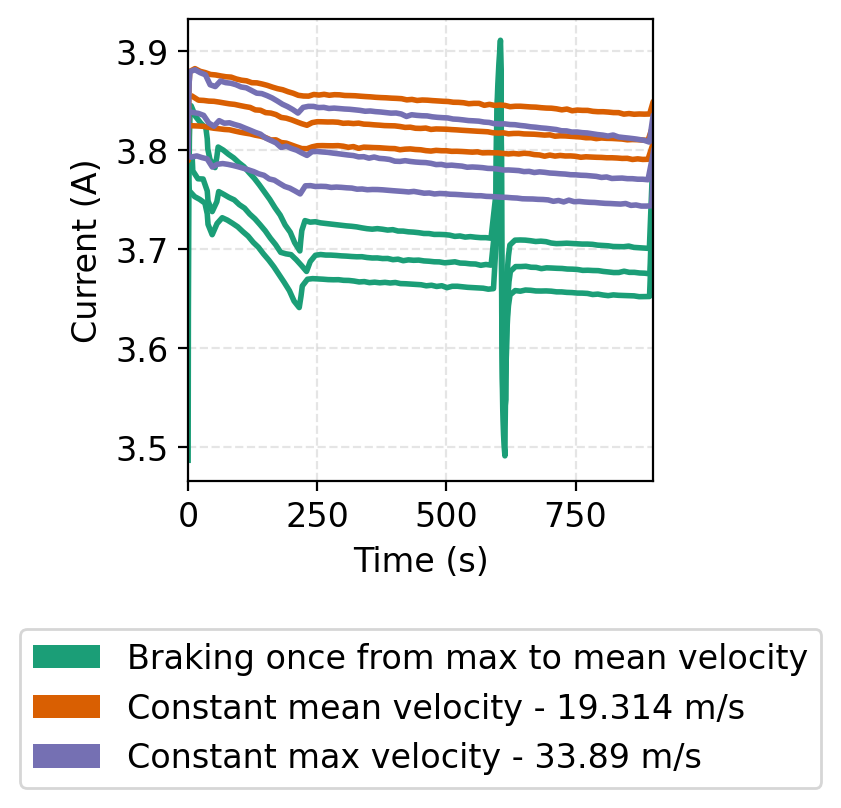

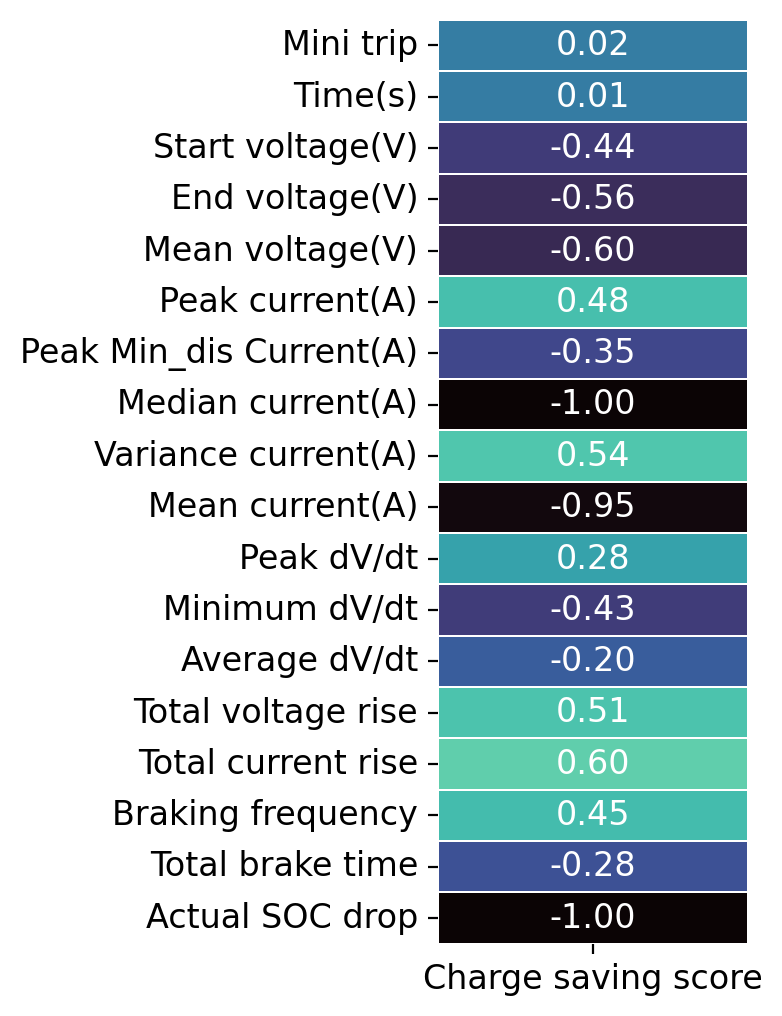

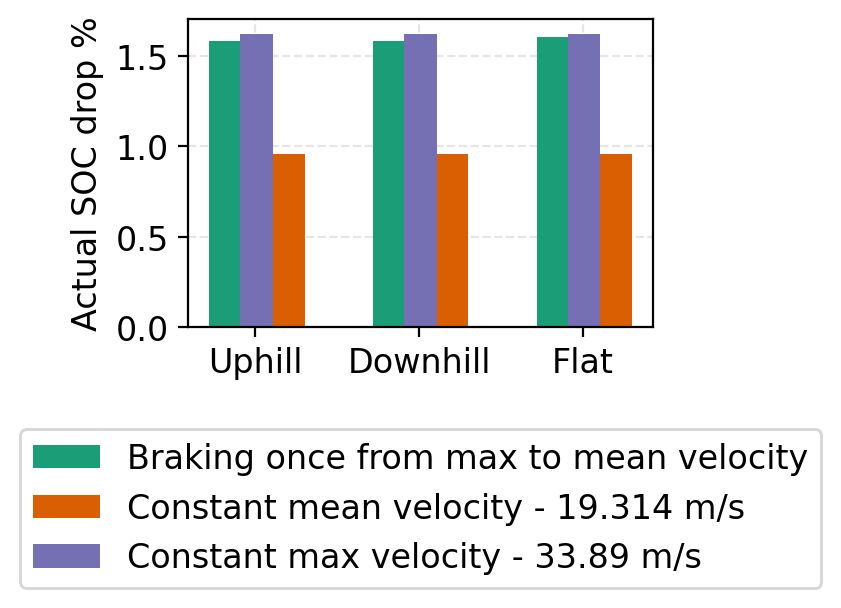

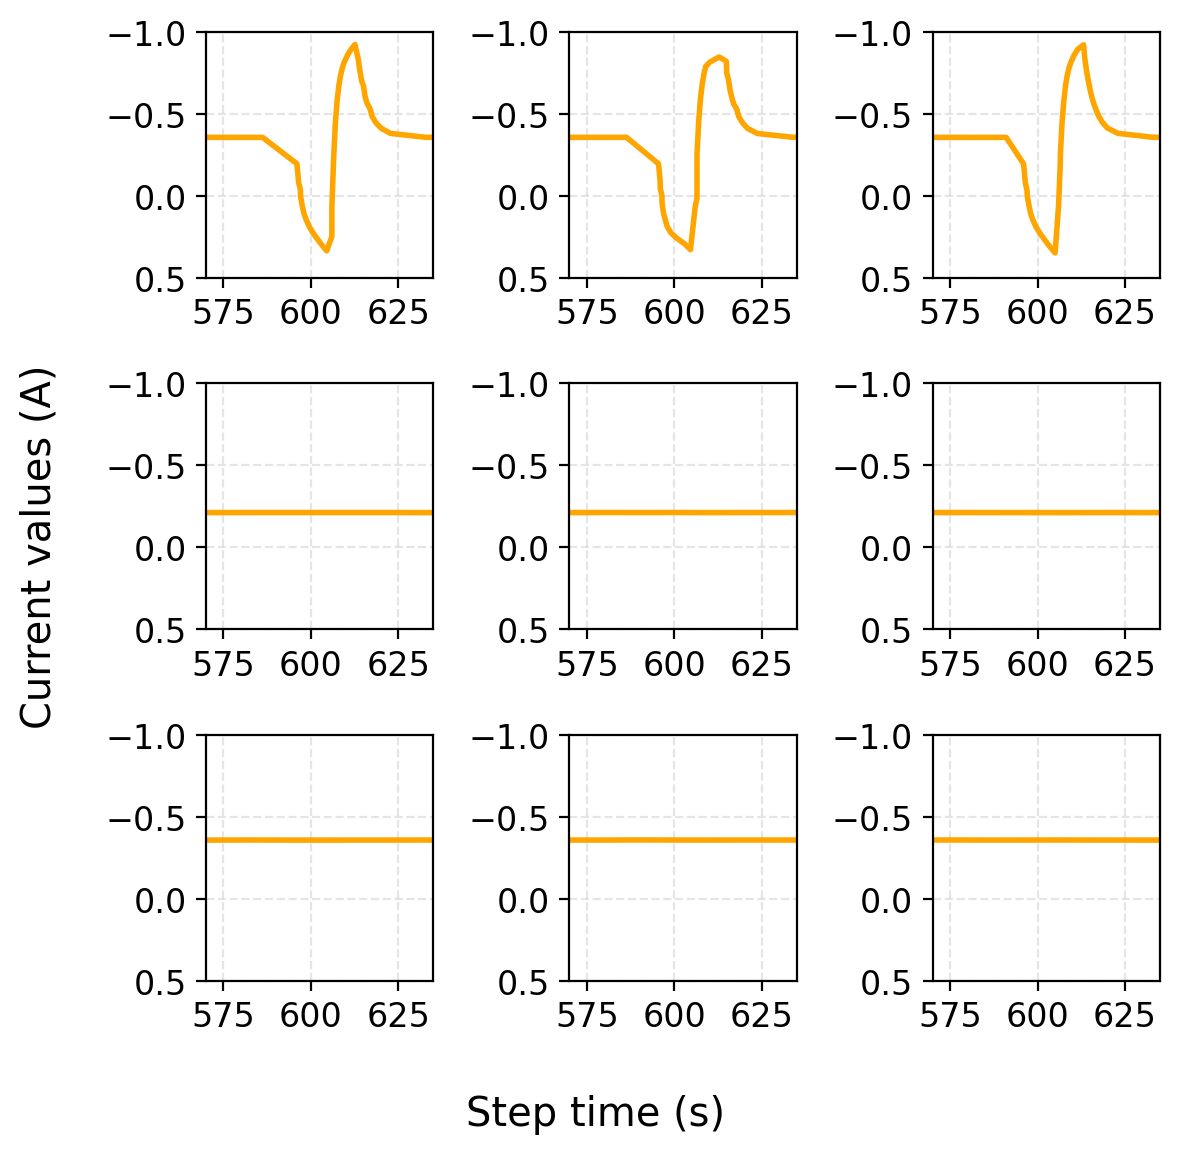

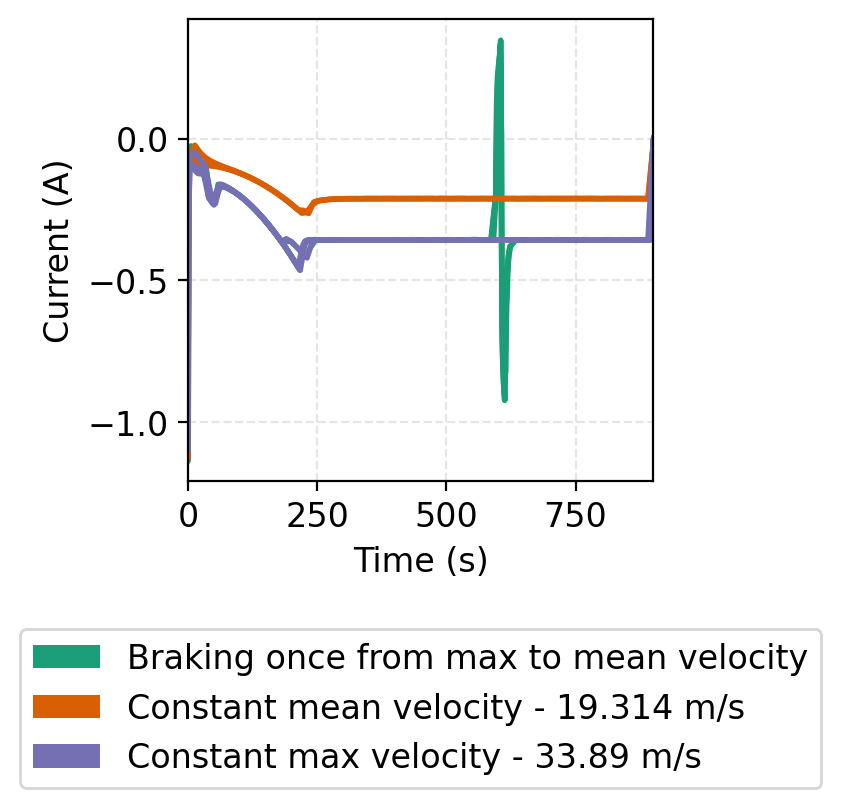

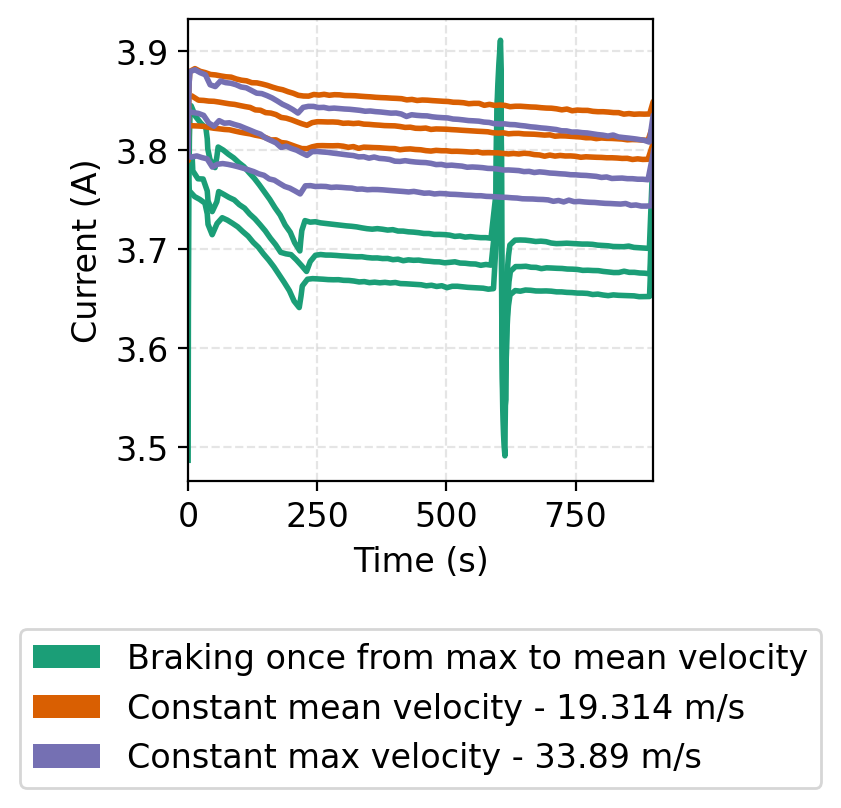

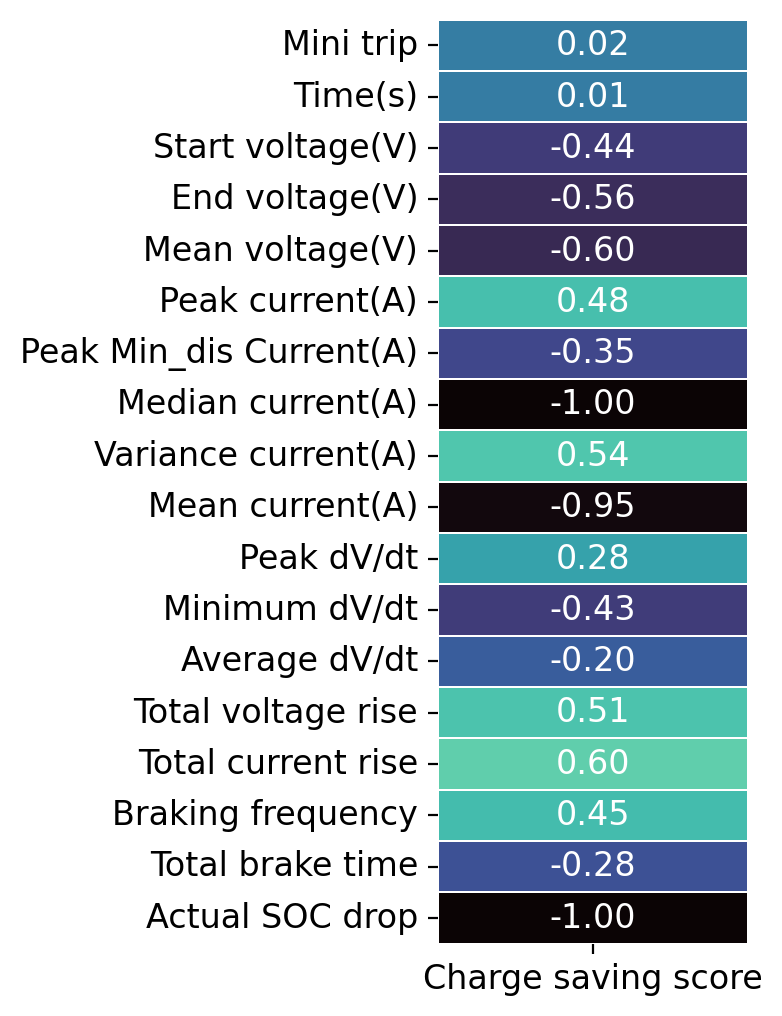

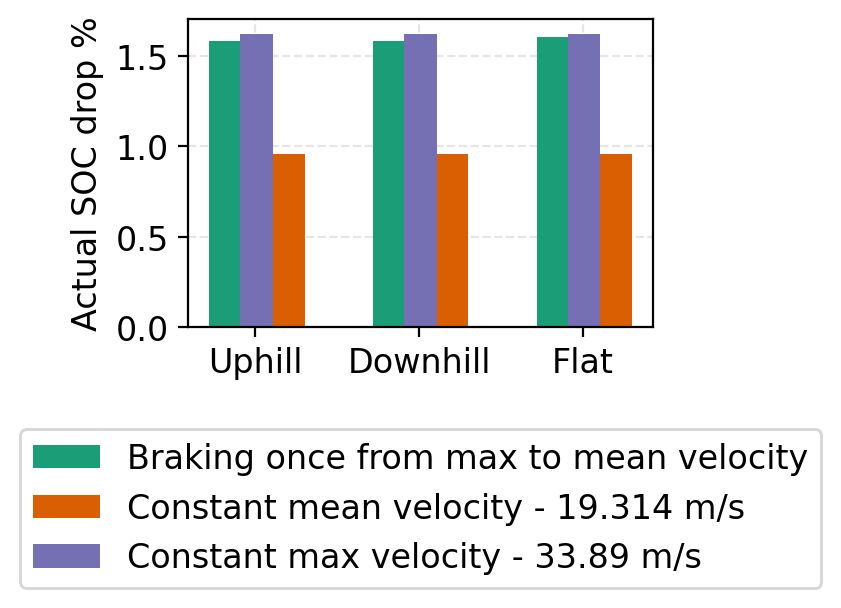

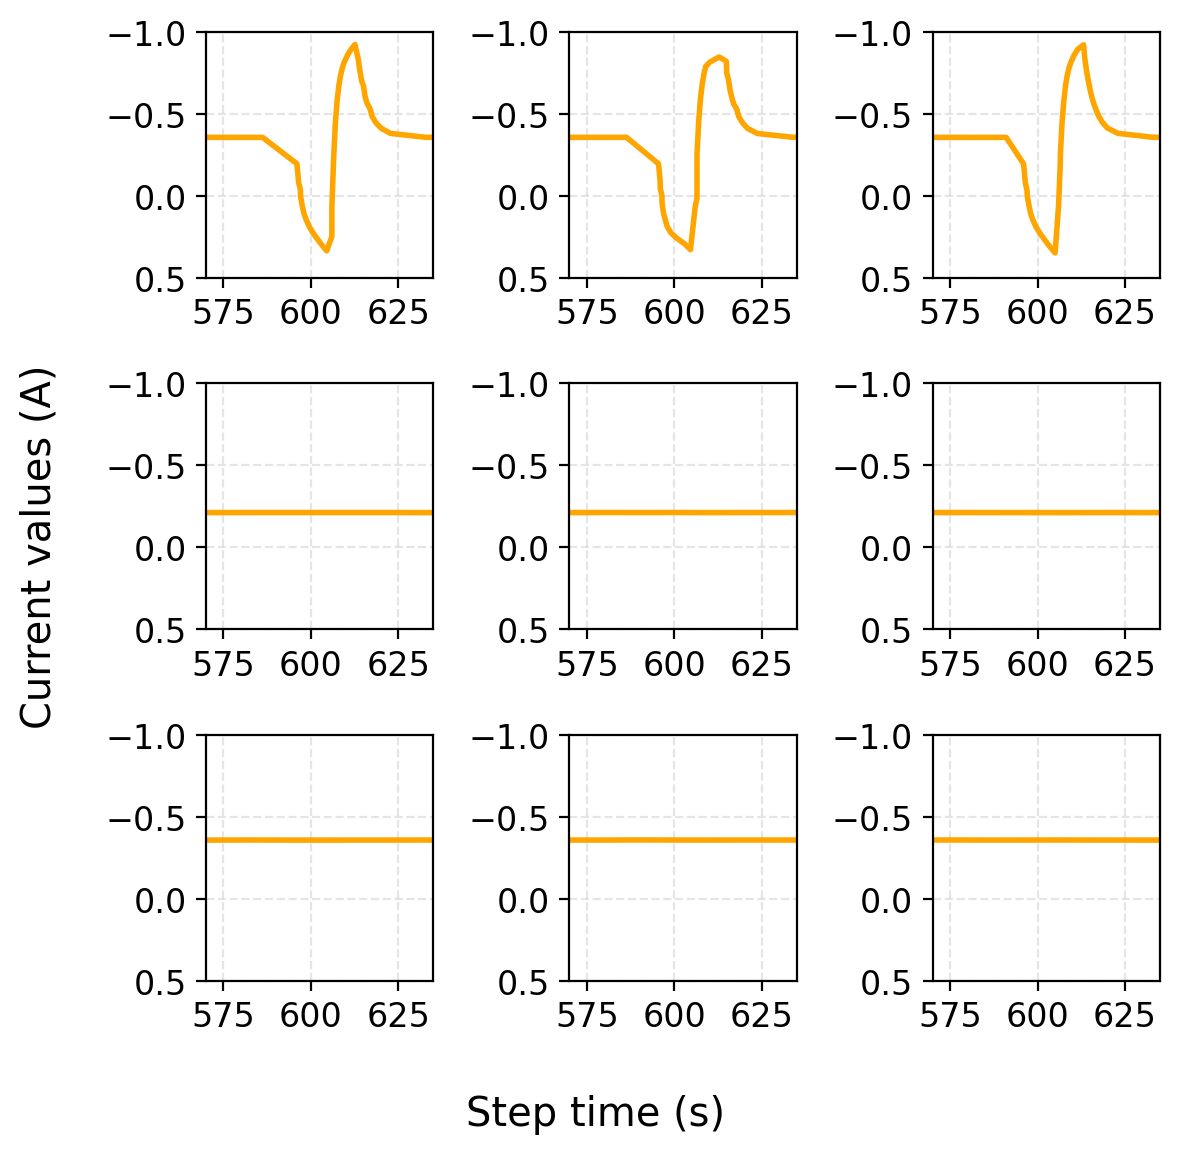

/var/folders/bv/5yzv5x3d5sb44fl8wn3sdr540000gn/T/ipykernel_67244/3217211228.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data1['Classification'].iloc[mt]= 'def_Up'
/var/folders/bv/5yzv5x3d5sb44fl8wn3sdr540000gn/T/ipykernel_67244/32172

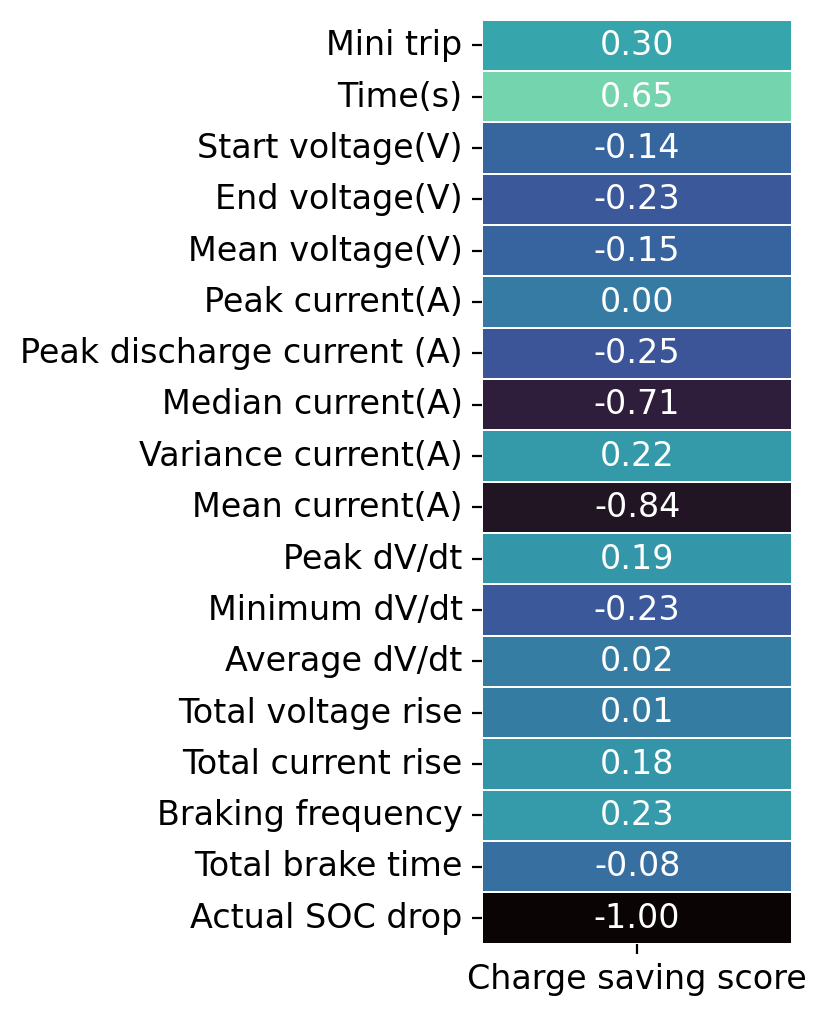

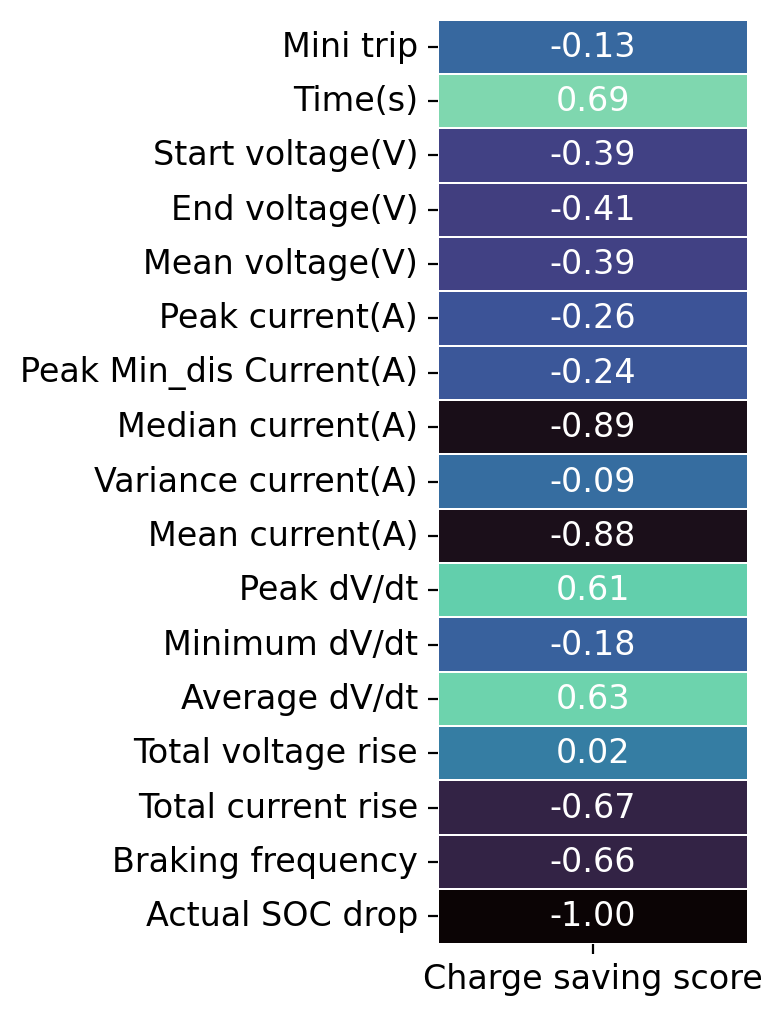

In [3]:
%run {TEST_DATA_NB}

In [4]:
info_data_2

,Mini Trip,Time(s),Start Voltage(V),End Voltage(V),Mean Voltage(V),Peak Current(A),Peak Min_dis Current(A),Median Current(A),Variance Current(A),Mean Current(A),Peak dV/dt,Min dV/dt,Avg dV/dt,Total Voltage Rise,Total Current Rise,Number of brakes,Total brake time,SOC_drop (%),Relative_SOC_drop
0,1,838.5301,3.625744,3.883290,3.870859,-0.015272,-1.126501,-0.221077,0.032698,-0.236519,0.123397,-0.032355,0.003618,0.333304,0.745126,9,277.8562,-1.714187,62.387902
1,2,830.7749,3.635924,3.808598,3.835656,-0.022005,-1.125478,-0.333996,0.019052,-0.300617,0.177656,-0.027619,0.010053,0.193704,0.221160,15,99.2912,-2.191082,79.744542
2,3,835.6806,3.618710,3.812423,3.830749,-0.022182,-1.129457,-0.285003,0.016756,-0.261694,0.123892,-0.033125,0.005763,0.225856,0.331414,14,161.7811,-1.941562,70.663244
3,4,832.0687,3.797764,3.779691,3.810151,-0.018094,-1.126538,-0.281176,0.018650,-0.282639,0.193953,-0.048424,0.007802,0.348449,0.631515,16,274.9793,-2.052681,74.707409
4,5,822.5755,3.878416,3.816445,3.815949,-0.024798,-0.385378,-0.247558,0.008041,-0.216769,0.112828,-0.027416,0.001599,0.295778,0.684379,9,275.6830,-1.626870,59.210020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,92,881.6387,3.793411,3.762675,3.765618,-0.064869,-0.450002,-0.274755,0.007911,-0.261357,0.045183,-0.009785,0.000633,0.108643,1.204570,15,140.5351,-2.146716,78.129824
92,93,896.1405,3.852625,3.709449,3.740650,-0.034600,-0.568212,-0.310640,0.013628,-0.303141,0.117966,-0.127090,0.000635,0.423559,0.941241,18,291.3320,-2.351125,85.569316
93,94,895.2206,3.801919,3.754945,3.701342,-0.030949,-0.818060,-0.296477,0.023855,-0.296967,0.112069,-0.182226,-0.001153,0.516790,1.184964,16,269.7200,-2.222724,80.896135
94,95,896.1301,3.777717,3.653281,3.689789,-0.034695,-0.533918,-0.291920,0.011841,-0.277675,0.115814,-0.039049,0.000697,0.452645,1.133279,14,253.8221,-2.212659,80.529824


### 1. Selecting features
We take the following four features as the input of our machine learning model: end voltage, median current, min dV/dt, and total current rise since they are more correlated to the output feature, which is SOC drop.

Correlation heatmap:

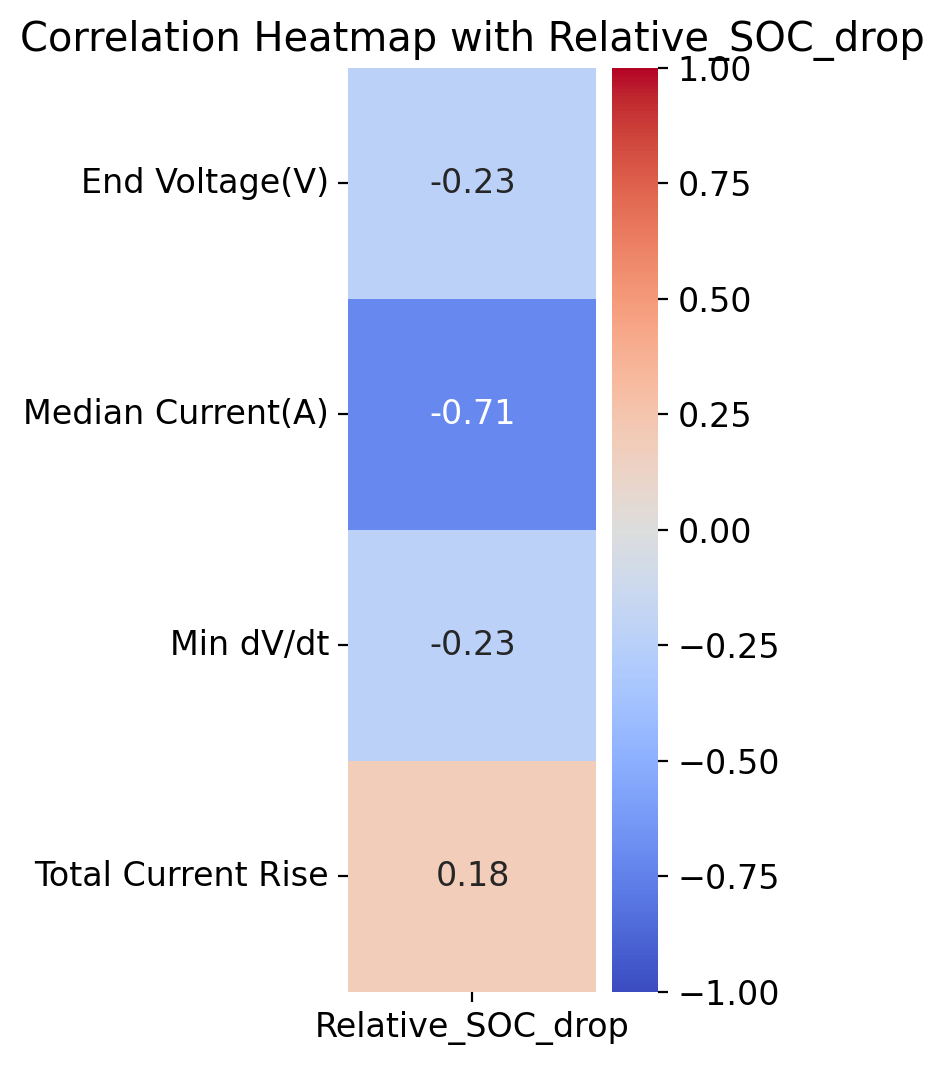

In [5]:
# Select only the relevant columns
selected_columns = ['End Voltage(V)', 'Median Current(A)', 'Min dV/dt', 'Total Current Rise', 'Relative_SOC_drop']
selected_data = info_data_2[selected_columns]

# Calculate the correlation matrix
corr_mat = selected_data.corr()

# Extract the correlation with 'Relative_SOC_drop' and drop the target row itself
target_corr = corr_mat[['Relative_SOC_drop']].drop(['Relative_SOC_drop'], axis=0)

# Plotting the heatmap
sns.heatmap(target_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, vmin=-1, vmax=1)
plt.title('Correlation Heatmap with Relative_SOC_drop')
plt.show()

Selecting features:

In [6]:
# Input (different features) is defined as X, output (SOC_drop) is defined as y
number_of_tests = np.shape(info_data_2.values)[0]
X = np.zeros((number_of_tests,4))
y = np.zeros(number_of_tests)

for i in range(number_of_tests):
    X[i,0] = info_data_2['End Voltage(V)'][i]
    X[i,1] = info_data_2['Median Current(A)'][i]
    X[i,2] = info_data_2['Min dV/dt'][i]
    X[i,3] = info_data_2['Total Current Rise'][i]
    y[i] = info_data_2['Relative_SOC_drop'][i]

print(f'{len(X)} points loaded in total, each with {len(X[0])} features')
print('Example point:', X[0])

96 points loaded in total, each with 4 features
Example point: [ 3.88329    -0.221077   -0.03235537  0.74512588]


In [7]:
number_of_new_tests = np.shape(info_data_test.values)[0]
X_new_test = np.zeros((number_of_new_tests,4))
y_new_test = np.zeros(number_of_new_tests)

for i in range(number_of_new_tests):
    X_new_test[i,0] = info_data_test['End Voltage(V)'][i]
    X_new_test[i,1] = info_data_test['Median Current(A)'][i]
    X_new_test[i,2] = info_data_test['Min dV/dt'][i]
    X_new_test[i,3] = info_data_test['Total Current Rise'][i]
    y_new_test[i] = info_data_test['Relative_SOC_drop'][i]

### 2. Divide the data into the train set and the test set
We want 80% of the data to be the train set and the rest (20%) to be the test set.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### 3. Build and test different models

#### (3.1) Linear model

In [9]:
model = LinearRegression()

# Now we use scikit learn to train a simple linear model
model.fit(X_train, y_train)

# And make predictions on the test set
y_pred = model.predict(X_test)
# Let's examine the mean absolute error and mean absolute percentage error
mae1 = mean_absolute_error(y_test, y_pred)
mape1 = mean_absolute_percentage_error(y_test, y_pred)

print('MAE:', mae1)
print('MAPE:', mape1)

MAE: 2.083346356416171
MAPE: 0.026449466591445165


Visualize the predicting result:

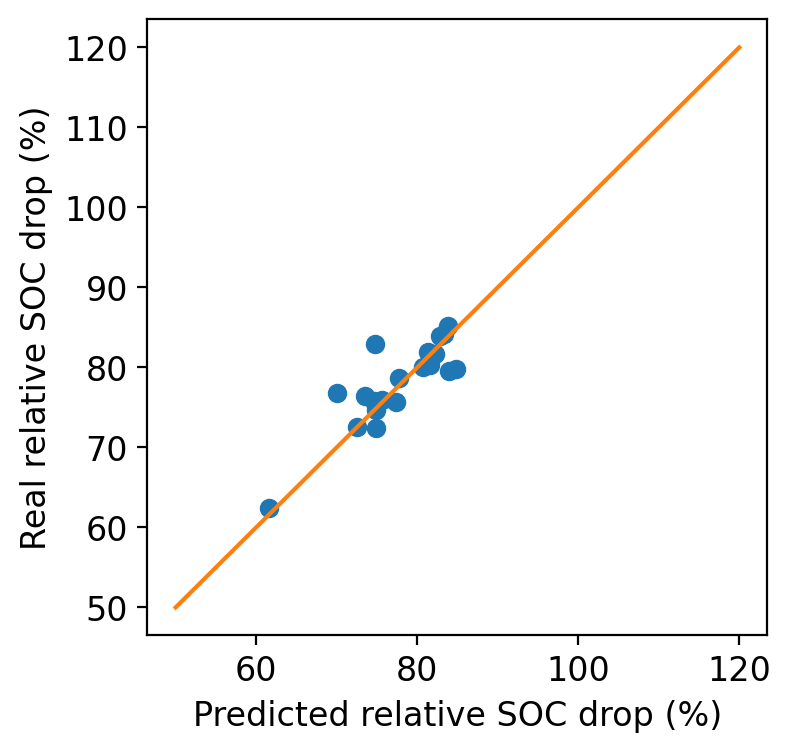

In [10]:
sns.reset_orig()
plt.rcdefaults()
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (4, 4)
plt.scatter(y_pred, y_test)
plt.plot([50,120], [50,120], color='C1')
plt.xlabel('Predicted relative SOC drop (%)')
plt.ylabel('Real relative SOC drop (%)')
plt.show()

#### (3.2) Decision tree model

In [11]:
model = DecisionTreeRegressor(random_state=0)

#Now we use scikit learn to train a decision tree model using k-fold cross validation and grid search to find the best model with hyperparameters tunned

#First we define that we use 5 folds to conduct cross validation
skf = KFold(n_splits=5, random_state=10, shuffle=True)
#Then use grid search to tune for the best hyper parameters
model_search = GridSearchCV(estimator=model, param_grid={'criterion':['squared_error', 'friedman_mse', 'absolute_error'], 'max_depth':np.arange(2,10)}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
#Fit the model
model_search.fit(X_train, y_train)
#Get the best model
model = model_search.best_estimator_

#And make predictions on the test set
y_pred = model.predict(X_test)
#Let's examine the mean absolute error and mean absolute percentage error
mae2 = mean_absolute_error(y_test, y_pred)
mape2 = mean_absolute_percentage_error(y_test, y_pred)

print('MAE:', mae2)
print('MAPE:', mape2)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-2.539, test=-2.476) neg_mean_squared_error: (train=-10.537, test=-9.235) r2: (train=0.704, test=0.679) total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-2.437, test=-3.073) neg_mean_squared_error: (train=-9.626, test=-13.981) r2: (train=0.747, test=0.311) total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-2.658, test=-2.562) neg_mean_squared_error: (train=-10.223, test=-11.642) r2: (train=0.643, test=0.795) total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-2.384, test=-3.399) neg_mean_squared_error: (train=-8.898, test=-20.568) r2: (train=0.761, test=-0.006) total time=   0.0s
[CV 5/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-2.515, test=-2.784) neg_mean

Visualize the predicting result:

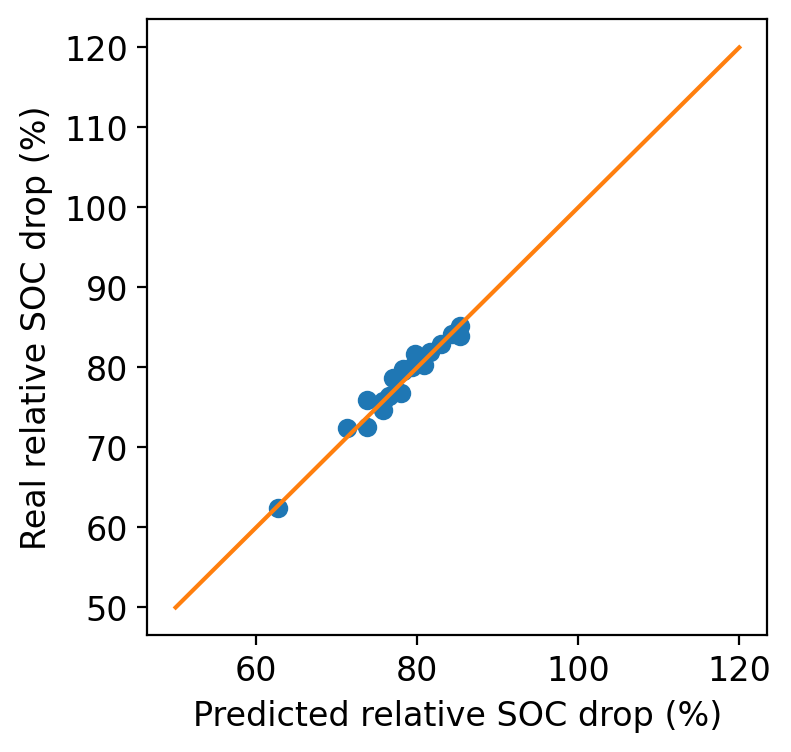

In [12]:
plt.figure()
plt.scatter(y_pred, y_test)
plt.plot([50,120], [50,120], color='C1')
plt.xlabel('Predicted relative SOC drop (%)')
plt.ylabel('Real relative SOC drop (%)')
plt.show()

#### (3.3) Extremely randomized tree model
Extra-trees differ from classic decision trees in the way they are built. When looking for the best split to separate the samples of a node into two groups, random splits are drawn for each of the *max_features* randomly selected features and the best split among those is chosen. When *max_features* is set 1, this amounts to building a totally random decision tree.

In [13]:
model = ExtraTreeRegressor(random_state=0)

#Now we use scikit learn to train an extremely randomized tree model using k-fold cross validation and grid search to find the best model with hyperparameters tunned
model_search = GridSearchCV(estimator=model, param_grid={'criterion':['squared_error', 'friedman_mse', 'absolute_error'], 'max_depth':np.arange(2,10)}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
model_search.fit(X_train, y_train)
model = model_search.best_estimator_

#And make predictions on the test set
y_pred = model.predict(X_test)
#Let's examine the mean absolute error and mean absolute percentage error
mae3 = mean_absolute_error(y_test, y_pred)
mape3 = mean_absolute_percentage_error(y_test, y_pred)

print('MAE:', mae3)
print('MAPE:', mape3)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-3.718, test=-4.273) neg_mean_squared_error: (train=-23.924, test=-23.542) r2: (train=0.328, test=0.182) total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-3.804, test=-3.994) neg_mean_squared_error: (train=-22.818, test=-24.632) r2: (train=0.400, test=-0.214) total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-3.724, test=-5.145) neg_mean_squared_error: (train=-23.187, test=-51.823) r2: (train=0.190, test=0.086) total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-4.005, test=-2.937) neg_mean_squared_error: (train=-25.310, test=-14.612) r2: (train=0.320, test=0.285) total time=   0.0s
[CV 5/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-3.532, test=-3.688) neg_m

Visualize the predicting result:

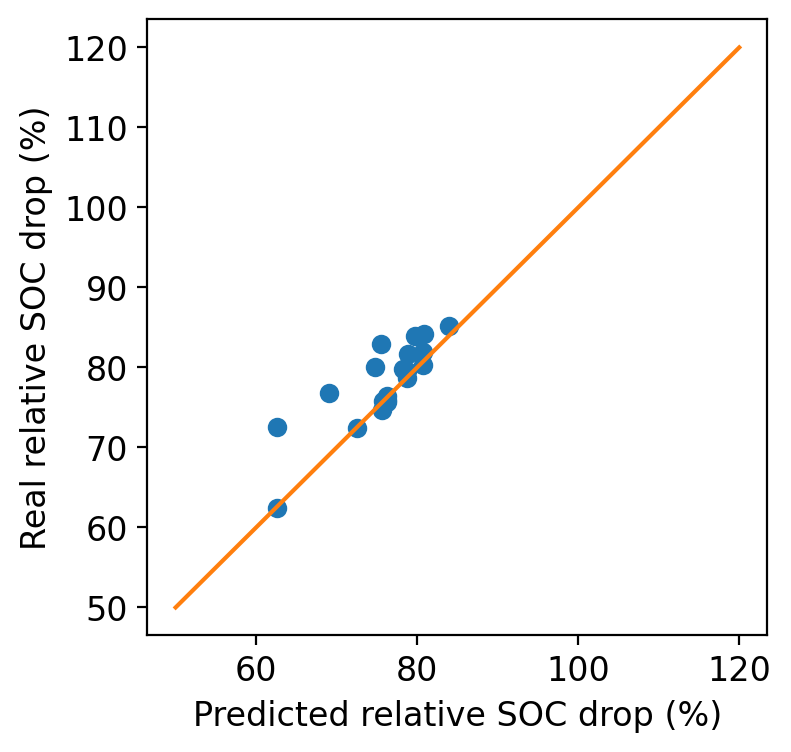

In [14]:
plt.figure()
plt.scatter(y_pred, y_test)
plt.plot([50,120], [50,120], color='C1')
plt.xlabel('Predicted relative SOC drop (%)')
plt.ylabel('Real relative SOC drop (%)')
plt.show()

#### (3.4) Random forest model
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [15]:
model = RandomForestRegressor(random_state=0)

#Now we use scikit learn to train a random forest model using k-fold cross validation and grid search to find the best model with hyperparameters tunned
model_search = GridSearchCV(estimator=model, param_grid={'criterion':['squared_error', 'friedman_mse', 'absolute_error'], 'max_depth':np.arange(2,10)}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
model_search.fit(X_train, y_train)
model = model_search.best_estimator_

#And make predictions on the test set
y_pred = model.predict(X_test)
#Let's examine the mean absolute error and mean absolute percentage error
mae4 = mean_absolute_error(y_test, y_pred)
mape4 = mean_absolute_percentage_error(y_test, y_pred)

print('MAE:', mae4)
print('MAPE:', mape4)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-2.262, test=-2.406) neg_mean_squared_error: (train=-7.669, test=-8.156) r2: (train=0.785, test=0.717) total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-2.137, test=-2.887) neg_mean_squared_error: (train=-7.094, test=-13.427) r2: (train=0.814, test=0.338) total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-2.266, test=-2.858) neg_mean_squared_error: (train=-7.274, test=-16.913) r2: (train=0.746, test=0.702) total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-2.242, test=-3.555) neg_mean_squared_error: (train=-7.653, test=-22.201) r2: (train=0.795, test=-0.086) total time=   0.0s
[CV 5/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-2.199, test=-2.596) neg_mean_s

Visualize the predicting result:

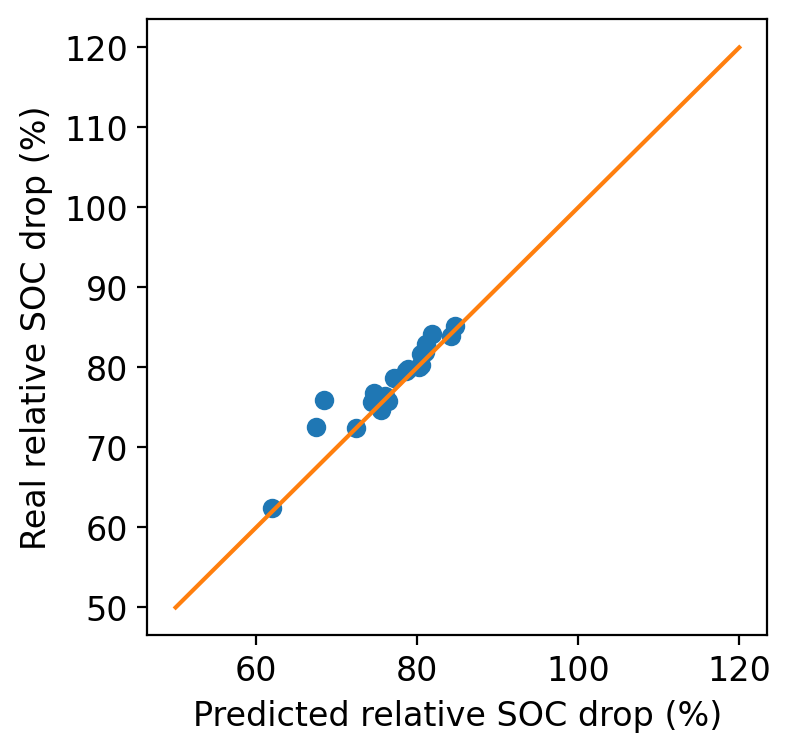

In [16]:
plt.figure()
plt.scatter(y_pred, y_test)
plt.plot([50,120], [50,120], color='C1')
plt.xlabel('Predicted relative SOC drop (%)')
plt.ylabel('Real relative SOC drop (%)')
plt.show()

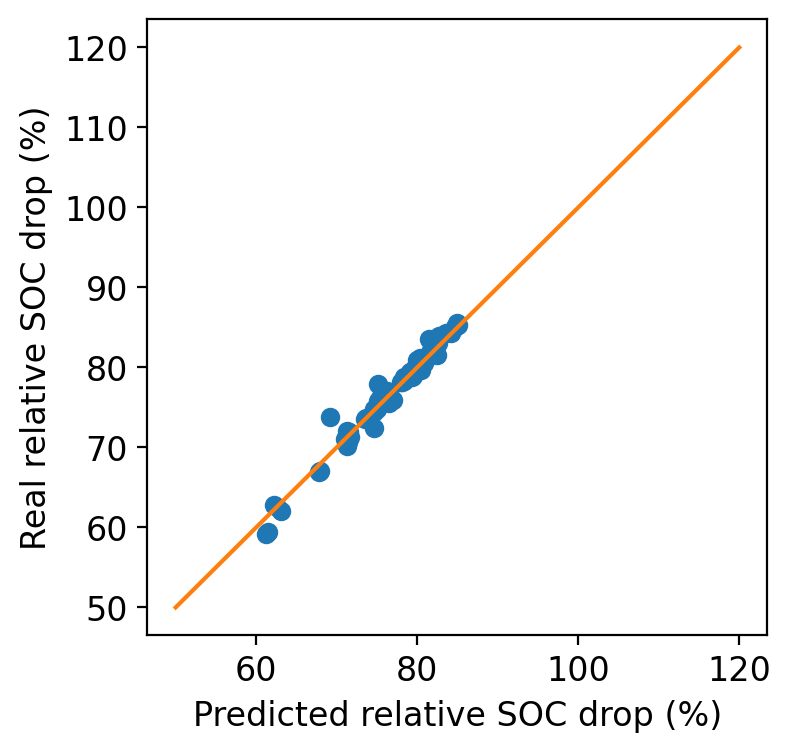

MAE: 0.6220842458253111
MAPE: 0.008333740666681543


In [17]:
y_pred_train = model.predict(X_train)
plt.figure()
plt.scatter(y_pred_train, y_train)
plt.plot([50,120], [50,120], color='C1')
plt.xlabel('Predicted relative SOC drop (%)')
plt.ylabel('Real relative SOC drop (%)')
plt.show()

mae4 = mean_absolute_error(y_train, y_pred_train)
mape4 = mean_absolute_percentage_error(y_train, y_pred_train)

print('MAE:', mae4)
print('MAPE:', mape4)

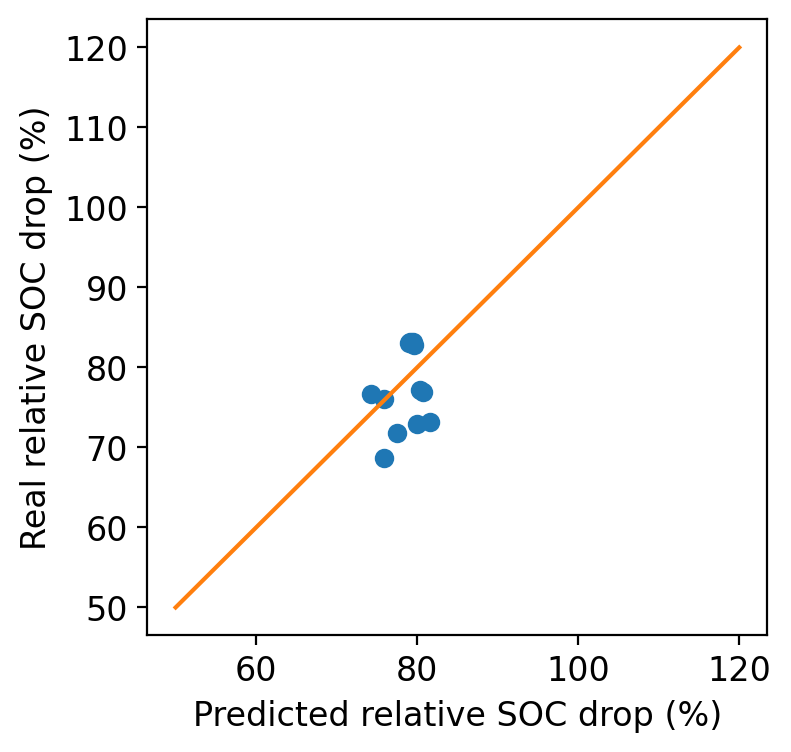

MAE: 4.417741584445479
MAPE: 0.05847991714384577


In [18]:
y_pred_new_test = model.predict(X_new_test)
plt.figure()
plt.scatter(y_pred_new_test, y_new_test)
plt.plot([50,120], [50,120], color='C1')
plt.xlabel('Predicted relative SOC drop (%)')
plt.ylabel('Real relative SOC drop (%)')
plt.show()

mae4 = mean_absolute_error(y_new_test, y_pred_new_test)
mape4 = mean_absolute_percentage_error(y_new_test, y_pred_new_test)

print('MAE:', mae4)
print('MAPE:', mape4)

In [19]:
np.savez(MISC_DIR / 'predictions_and_labels_for_battery_data.npz', 
         y_pred_train_3 = y_pred_train, 
         y_train_3 = y_train, 
         y_pred_val_3 = y_pred, 
         y_val_3 = y_test, 
         y_pred_test_3 = y_pred_new_test,
         y_test_3 = y_new_test)

#### (3.5) k-nearest neighbors model
The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set.

In [20]:
model = KNeighborsRegressor()

#Now we use scikit learn to train a k-nearest neighbors model using k-fold cross validation and grid search to find the best model with hyperparameters tunned
model_search = GridSearchCV(estimator=model, param_grid={'n_neighbors':np.arange(2,10), 'weights':['uniform', 'distance'], 'algorithm':['ball_tree', 'kd_tree', 'brute']}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
model_search.fit(X_train, y_train)
model = model_search.best_estimator_

#And make predictions on the test set
y_pred = model.predict(X_test)
#Let's examine the mean absolute error and mean absolute percentage error
mae5 = mean_absolute_error(y_test, y_pred)
mape5 = mean_absolute_percentage_error(y_test, y_pred)

print('MAE:', mae5)
print('MAPE:', mape5)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END algorithm=ball_tree, n_neighbors=2, weights=uniform; neg_mean_absolute_error: (train=-1.701, test=-2.642) neg_mean_squared_error: (train=-7.523, test=-12.128) r2: (train=0.789, test=0.579) total time=   0.0s
[CV 2/5] END algorithm=ball_tree, n_neighbors=2, weights=uniform; neg_mean_absolute_error: (train=-1.206, test=-3.680) neg_mean_squared_error: (train=-4.716, test=-28.727) r2: (train=0.876, test=-0.416) total time=   0.0s
[CV 3/5] END algorithm=ball_tree, n_neighbors=2, weights=uniform; neg_mean_absolute_error: (train=-1.253, test=-6.163) neg_mean_squared_error: (train=-4.594, test=-76.936) r2: (train=0.840, test=-0.356) total time=   0.0s
[CV 4/5] END algorithm=ball_tree, n_neighbors=2, weights=uniform; neg_mean_absolute_error: (train=-1.973, test=-2.732) neg_mean_squared_error: (train=-9.310, test=-10.524) r2: (train=0.750, test=0.485) total time=   0.0s
[CV 5/5] END algorithm=ball_tree, n_neighbors=2, wei

Visualize the predicting result:

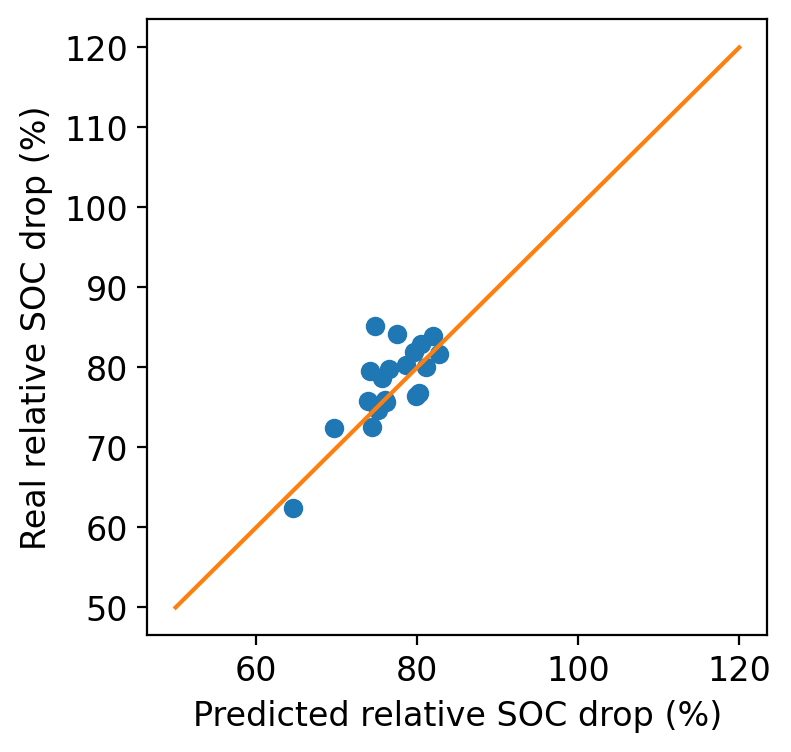

In [21]:
plt.figure()
plt.scatter(y_pred, y_test)
plt.plot([50,120], [50,120], color='C1')
plt.xlabel('Predicted relative SOC drop (%)')
plt.ylabel('Real relative SOC drop (%)')
plt.show()

#### (3.6) Gaussian process model

In [22]:
model = GaussianProcessRegressor(n_restarts_optimizer=5,normalize_y=True, random_state=0)

#Now we use scikit learn to train a random forest model using k-fold cross validation and grid search to find the best model with hyperparameters tunned
model_search = GridSearchCV(estimator=model, param_grid={'kernel': [1.0*RBF(length_scale=1),1.0*Matern(length_scale=1.0, nu=1.5),1.0*RationalQuadratic(alpha=0.1, length_scale=1.0),1.0*ExpSineSquared(length_scale=1.0, periodicity=1.0)], 'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1.0]}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
model_search.fit(X_train, y_train)
model = model_search.best_estimator_

#And make predictions on the test set
y_pred = model.predict(X_test)
#Let's examine the mean absolute error and mean absolute percentage error
mae6 = mean_absolute_error(y_test, y_pred)
mape6 = mean_absolute_percentage_error(y_test, y_pred)

print('MAE:', mae6)
print('MAPE:', mape6)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END alpha=0.0001, kernel=1**2 * RBF(length_scale=1); neg_mean_absolute_error: (train=-0.004, test=-2.421) neg_mean_squared_error: (train=-0.000, test=-10.493) r2: (train=1.000, test=0.635) total time=   0.7s
[CV 2/5] END alpha=0.0001, kernel=1**2 * RBF(length_scale=1); neg_mean_absolute_error: (train=-0.001, test=-2.936) neg_mean_squared_error: (train=-0.000, test=-15.793) r2: (train=1.000, test=0.222) total time=   0.2s
[CV 3/5] END alpha=0.0001, kernel=1**2 * RBF(length_scale=1); neg_mean_absolute_error: (train=-0.001, test=-4.218) neg_mean_squared_error: (train=-0.000, test=-42.086) r2: (train=1.000, test=0.258) total time=   0.3s
[CV 4/5] END alpha=0.0001, kernel=1**2 * RBF(length_scale=1); neg_mean_absolute_error: (train=-0.001, test=-1.841) neg_mean_squared_error: (train=-0.000, test=-6.633) r2: (train=1.000, test=0.675) total time=   0.2s
[CV 5/5] END alpha=0.0001, kernel=1**2 * RBF(length_scale=1); neg_mean_

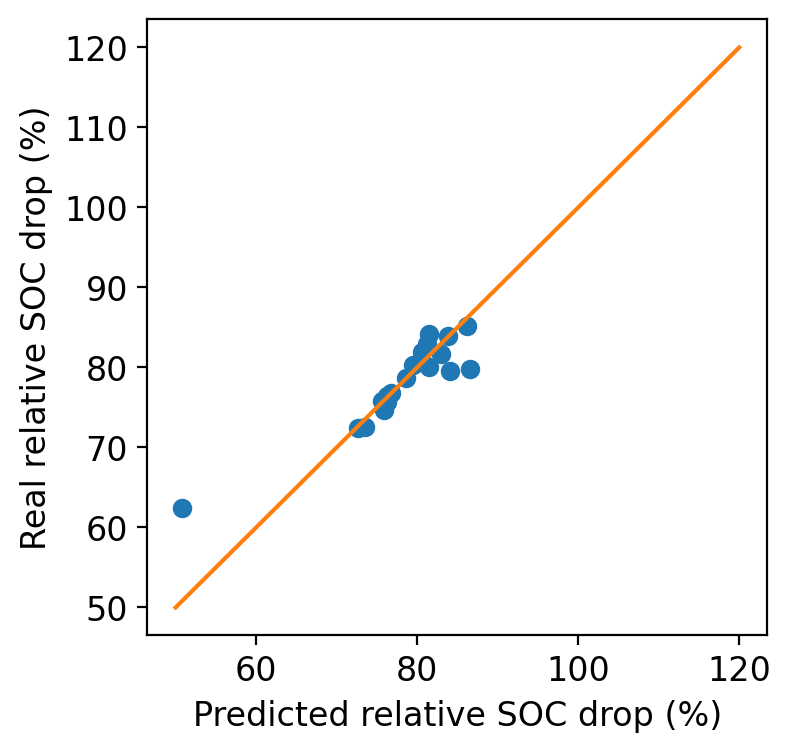

In [23]:
plt.figure()
plt.scatter(y_pred, y_test)
plt.plot([50,120], [50,120], color='C1')
plt.xlabel('Predicted relative SOC drop (%)')
plt.ylabel('Real relative SOC drop (%)')
plt.show()

#### (3.7) Summary
Compare the mean absolute percent error of each regression method. Each method is repeated 10 times by random train and test data, and average mean absolute percent errors are taken in order to make the results more general.

100%|██████████| 10/10 [04:19<00:00, 25.93s/it]


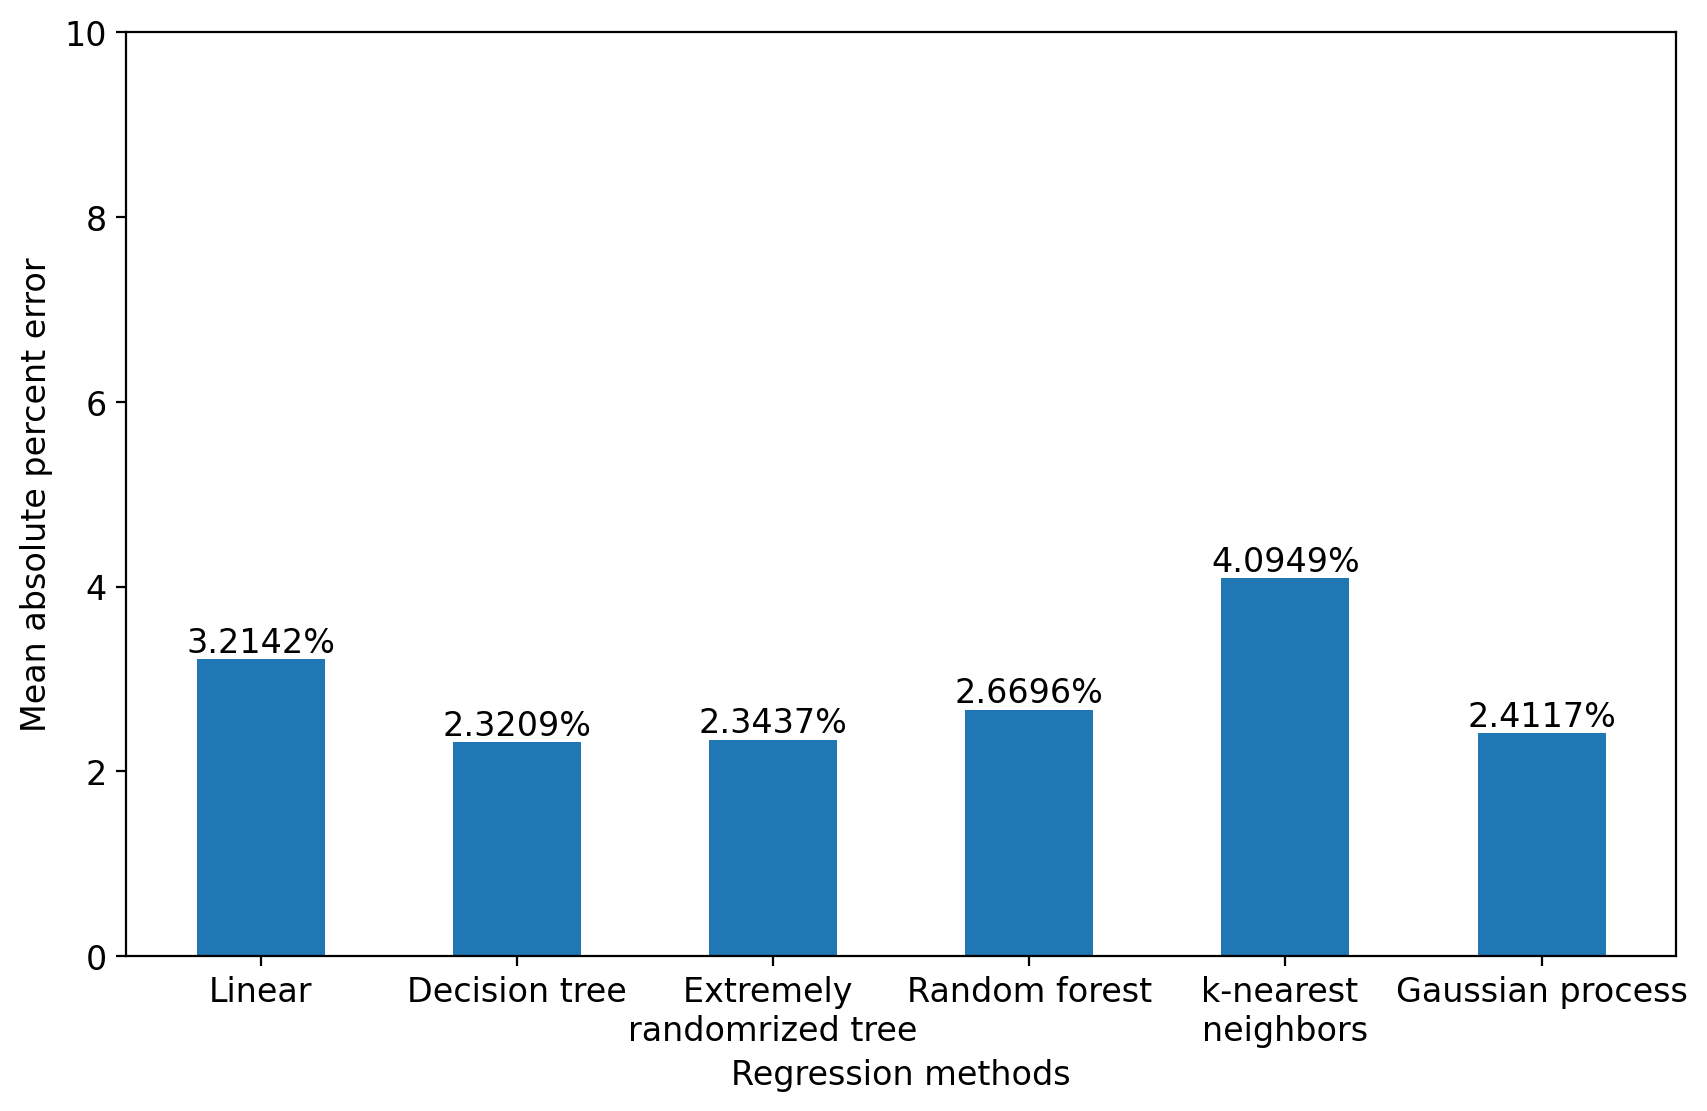

In [24]:
mape_t=np.zeros((10,6))
original_stdout = sys.stdout

for i in tqdm(range(10)):
    sys.stdout = open(os.devnull, 'w')
    
    mape=[]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mape.append(mean_absolute_percentage_error(y_test, y_pred))

    model = DecisionTreeRegressor()
    skf = KFold(n_splits=5, random_state=10, shuffle=True)
    model_search = GridSearchCV(estimator=model, param_grid={'criterion':['squared_error', 'friedman_mse', 'absolute_error'], 'max_depth':np.arange(2,10)}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
    model_search.fit(X_train, y_train)
    model = model_search.best_estimator_
    y_pred = model.predict(X_test)
    mape.append(mean_absolute_percentage_error(y_test, y_pred))

    model = ExtraTreeRegressor()
    model_search = GridSearchCV(estimator=model, param_grid={'criterion':['squared_error', 'friedman_mse', 'absolute_error'], 'max_depth':np.arange(2,10)}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
    model_search.fit(X_train, y_train)
    model = model_search.best_estimator_
    y_pred = model.predict(X_test)
    mape.append(mean_absolute_percentage_error(y_test, y_pred))

    model = RandomForestRegressor()
    model_search = GridSearchCV(estimator=model, param_grid={'criterion':['squared_error', 'friedman_mse', 'absolute_error'], 'max_depth':np.arange(2,10)}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
    model_search.fit(X_train, y_train)
    model = model_search.best_estimator_
    y_pred = model.predict(X_test)
    mape.append(mean_absolute_percentage_error(y_test, y_pred))

    model = KNeighborsRegressor()
    model_search = GridSearchCV(estimator=model, param_grid={'n_neighbors':np.arange(2,10), 'weights':['uniform', 'distance'], 'algorithm':['ball_tree', 'kd_tree', 'brute']}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
    model_search.fit(X_train, y_train)
    model = model_search.best_estimator_
    y_pred = model.predict(X_test)
    mape.append(mean_absolute_percentage_error(y_test, y_pred))

    model = GaussianProcessRegressor(n_restarts_optimizer=5,normalize_y=True, random_state=0)
    model_search = GridSearchCV(estimator=model, param_grid={'kernel': [1.0*RBF(length_scale=1),1.0*Matern(length_scale=1.0, nu=1.5),1.0*RationalQuadratic(alpha=0.1, length_scale=1.0),1.0*ExpSineSquared(length_scale=1.0, periodicity=1.0)], 'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1.0]}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
    model_search.fit(X_train, y_train)
    model = model_search.best_estimator_
    y_pred = model.predict(X_test)
    mape.append(mean_absolute_percentage_error(y_test, y_pred))

    mape_t[i]=mape
    sys.stdout = original_stdout

plt.figure(figsize = (10, 6))
bars=plt.bar(['Linear','Decision tree','Extremely \nrandomrized tree','Random forest','k-nearest \nneighbors','Gaussian process'],np.mean(mape_t,axis=0)*100,width = 0.5)
plt.xlabel("Regression methods")
plt.ylabel("Mean absolute percent error")
plt.ylim([0,10])
plt.bar_label(bars, fmt='%.4f%%')
plt.show()

### 4. Benchmark how many seconds of data used for featurization affect the accuracy of prediction of SOC at 800 seconds

In this part, we will first obtain the SOC of all the time series data at 800 seconds. Then, we will cut all the data to 300 ~ $x$ seconds, and extract features from the already cut data. After that, we will use these features to predict the SOC at 800 seconds using different regression methods. We will increase $x$ from 325 to 800, with increments of 25, and observe the accuracy of prediction (mean absolute percent error) when $x$ is increasing. We will run the test for 10 times and take the average to ensure the accuracy of the result. The x axis of the plots will be calculated as (x-300) seconds.

In [25]:
def curve_plot(mape_t, label, color):
    # Calculate mean and standard error
    mean_mape = np.mean(mape_t, axis=0)
    std_error = np.std(mape_t, axis=0) / np.sqrt(mape_t.shape[0])

    # Calculate confidence interval
    confidence = 0.95
    n = mape_t.shape[0]
    t = np.abs(stats.t.ppf((1 - confidence) / 2, n - 1))
    margin_of_error = t * std_error
    confidence_interval = margin_of_error

    plt.plot(np.arange(25, 501, 25), mean_mape * 100, label = label, color = color)
    plt.fill_between(np.arange(25, 501, 25), (mean_mape - confidence_interval) * 100, (mean_mape + confidence_interval) * 100, alpha = 0.2, color = tuple(np.array(color) / 2))

In [26]:
def features_ext(dict):
    end_volts_arr = []
    med_curr_arr = []
    min_dvdt_arr = []
    curr_rise_arr = []
    soc_cc_arr = []
    
    for key in dict.keys():
        # End Voltage
        end_volts = dict[key]['Voltage (V)'].iloc[-1]
        end_volts_arr.append(end_volts)

        # Median Current
        med_curr = dict[key]['Current (A)'].median()
        med_curr_arr.append(med_curr)

        # Min dV/dt
        min_dvdt = dict[key]['dV/dt (V/s)'].min()
        min_dvdt_arr.append(min_dvdt)

        # Total Current Rise
        curr_rise = currdrop_sum(dict[key])
        curr_rise_arr.append(curr_rise)

        # SOC Drop
        discharge = dis_cap_drop(dict[key])
        soc_cc = (discharge / 3) * 100
        soc_cc_arr.append(soc_cc)

    info_data_2['End Voltage(V)'] = end_volts_arr
    info_data_2['Median Current(A)'] = med_curr_arr
    info_data_2['Min dV/dt'] = min_dvdt_arr
    info_data_2['Total Current Rise'] = curr_rise_arr
    info_data_2['SOC_drop (%)'] = soc_cc_arr
    info_data_2['Relative_SOC_drop'] = (((info_data_2['SOC_drop (%)'] - relative_soc) / relative_soc) + 1) * 100

    return info_data_2

In [27]:
def features_ext_test(dict_test):
    end_volts_arr = []
    med_curr_arr = []
    min_dvdt_arr = []
    curr_rise_arr = []
    soc_cc_arr = []

    for key in dict_test.keys():
        # End Voltage
        end_volts = dict_test[key]['Voltage (V)'].iloc[-1]
        end_volts_arr.append(end_volts)
        
        # Median Current
        med_curr = dict_test[key]['Current (A)'].median()
        med_curr_arr.append(med_curr)
        
        # Min dV/dt
        min_dvdt = dict_test[key]['dV/dt (V/s)'].min()
        min_dvdt_arr.append(min_dvdt)
        
        # Total Current Rise
        curr_rise = currdrop_sum(dict_test[key])
        curr_rise_arr.append(curr_rise)
        
        # Relative_SOC_drop
        discharge = dis_cap_drop(dict_test[key])
        soc_cc = (discharge / 3) * 100
        soc_cc_arr.append(soc_cc)
    
    info_data_test['End Voltage(V)'] = end_volts_arr
    info_data_test['Median Current(A)'] = med_curr_arr
    info_data_test['Min dV/dt'] = min_dvdt_arr
    info_data_test['Total Current Rise'] = curr_rise_arr
    info_data_test['SOC_drop (%)'] = soc_cc_arr
    info_data_test['Relative_SOC_drop'] = (((info_data_test['SOC_drop (%)'] - relative_soc) / relative_soc) + 1) * 100
    
    return info_data_test

In [ ]:
iteration = 10

mape_t1 = np.zeros((iteration, 20))
mape_t2 = np.zeros((iteration, 20))
mape_t3 = np.zeros((iteration, 20))
mape_t4 = np.zeros((iteration, 20))
mape_t5 = np.zeros((iteration, 20))
mape_t6 = np.zeros((iteration, 20))
mape_test_t1 = np.zeros((iteration, 20))
mape_test_t2 = np.zeros((iteration, 20))
mape_test_t3 = np.zeros((iteration, 20))
mape_test_t4 = np.zeros((iteration, 20))
mape_test_t5 = np.zeros((iteration, 20))
mape_test_t6 = np.zeros((iteration, 20))
original_stdout = sys.stdout

cut_dict = {}
data_list = []
for key in dict.keys():
    datafr = cut_time(dict[key], 300, 800)
    data_list.append(datafr)
cut_dict = {f'Minitrip{i+1}': dataf for i, dataf in enumerate(data_list)}

cut_data = features_ext(cut_dict)

number_of_tests = np.shape(cut_data.values)[0]
y = np.zeros(number_of_tests)

for i in range(number_of_tests):
    y[i] = cut_data['Relative_SOC_drop'][i]

cut_dict = {}
data_list = []
for key in dict_test.keys():
    datafr = cut_time(dict_test[key], 300, 800)
    data_list.append(datafr)
cut_dict = {f'Minitrip{i+1}': dataf for i, dataf in enumerate(data_list)}

cut_data = features_ext_test(cut_dict)

number_of_tests = np.shape(cut_data.values)[0]
y_test2 = np.zeros(number_of_tests)

for i in range(number_of_tests):
    y_test2[i] = cut_data['Relative_SOC_drop'][i]

for ii in tqdm(range(iteration)):
    mape1 = []
    mape2 = []
    mape3 = []
    mape4 = []
    mape5 = []
    mape6 = []
    mape_test_1 = []
    mape_test_2 = []
    mape_test_3 = []
    mape_test_4 = []
    mape_test_5 = []
    mape_test_6 = []

    for kk in range(325, 801, 25):
        sys.stdout = open(os.devnull, 'w')

        cut_dict = {}
        data_list = []
        for key in dict.keys():
            datafr = cut_time(dict[key], 300, kk)
            data_list.append(datafr)
        cut_dict = {f'Minitrip{i+1}': dataf for i, dataf in enumerate(data_list)}

        cut_data = features_ext(cut_dict)

        number_of_tests = np.shape(cut_data.values)[0]
        X = np.zeros((number_of_tests, 4))

        for i in range(number_of_tests):
            X[i, 0] = cut_data['End Voltage(V)'][i]
            X[i, 1] = cut_data['Median Current(A)'][i]
            X[i, 2] = cut_data['Min dV/dt'][i]
            X[i, 3] = cut_data['Total Current Rise'][i]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        cut_dict = {}
        data_list = []
        for key in dict_test.keys():
            datafr = cut_time(dict_test[key], 300, kk)
            data_list.append(datafr)
        cut_dict = {f'Minitrip{i+1}': dataf for i, dataf in enumerate(data_list)}

        cut_data = features_ext_test(cut_dict)

        number_of_tests = np.shape(cut_data.values)[0]
        X_test2 = np.zeros((number_of_tests, 4))

        for i in range(number_of_tests):
            X_test2[i, 0] = cut_data['End Voltage(V)'][i]
            X_test2[i, 1] = cut_data['Median Current(A)'][i]
            X_test2[i, 2] = cut_data['Min dV/dt'][i]
            X_test2[i, 3] = cut_data['Total Current Rise'][i]
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mape1.append(mean_absolute_percentage_error(y_test, y_pred))
        y_pred2 = model.predict(X_test2)
        mape_test_1.append(mean_absolute_percentage_error(y_test2, y_pred2))

        model = DecisionTreeRegressor()
        skf = KFold(n_splits=5, random_state=10, shuffle=True)
        model_search = GridSearchCV(estimator=model, param_grid={'criterion':['squared_error', 'friedman_mse', 'absolute_error'], 'max_depth':np.arange(2,10)}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
        model_search.fit(X_train, y_train)
        model = model_search.best_estimator_
        y_pred = model.predict(X_test)
        mape2.append(mean_absolute_percentage_error(y_test, y_pred))
        y_pred2 = model.predict(X_test2)
        mape_test_2.append(mean_absolute_percentage_error(y_test2, y_pred2))

        model = ExtraTreeRegressor()
        model_search = GridSearchCV(estimator=model, param_grid={'criterion':['squared_error', 'friedman_mse', 'absolute_error'], 'max_depth':np.arange(2,10)}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
        model_search.fit(X_train, y_train)
        model = model_search.best_estimator_
        y_pred = model.predict(X_test)
        mape3.append(mean_absolute_percentage_error(y_test, y_pred))
        y_pred2 = model.predict(X_test2)
        mape_test_3.append(mean_absolute_percentage_error(y_test2, y_pred2))

        model = RandomForestRegressor()
        model_search = GridSearchCV(estimator=model, param_grid={'criterion':['squared_error', 'friedman_mse', 'absolute_error'], 'max_depth':np.arange(2,10)}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
        model_search.fit(X_train, y_train)
        model = model_search.best_estimator_
        y_pred = model.predict(X_test)
        mape4.append(mean_absolute_percentage_error(y_test, y_pred))
        y_pred2 = model.predict(X_test2)
        mape_test_4.append(mean_absolute_percentage_error(y_test2, y_pred2))

        model = KNeighborsRegressor()
        model_search = GridSearchCV(estimator=model, param_grid={'n_neighbors':np.arange(2,10), 'weights':['uniform', 'distance'], 'algorithm':['ball_tree', 'kd_tree', 'brute']}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
        model_search.fit(X_train, y_train)
        model = model_search.best_estimator_
        y_pred = model.predict(X_test)
        mape5.append(mean_absolute_percentage_error(y_test, y_pred))
        y_pred2 = model.predict(X_test2)
        mape_test_5.append(mean_absolute_percentage_error(y_test2, y_pred2))

        model = GaussianProcessRegressor(n_restarts_optimizer=5,normalize_y=True, random_state=0)
        model_search = GridSearchCV(estimator=model, param_grid={'kernel': [1.0*RBF(length_scale=1),1.0*Matern(length_scale=1.0, nu=1.5),1.0*RationalQuadratic(alpha=0.1, length_scale=1.0),1.0*ExpSineSquared(length_scale=1.0, periodicity=1.0)], 'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1.0]}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
        model_search.fit(X_train, y_train)
        model = model_search.best_estimator_
        y_pred = model.predict(X_test)
        mape6.append(mean_absolute_percentage_error(y_test, y_pred))
        y_pred2 = model.predict(X_test2)
        mape_test_6.append(mean_absolute_percentage_error(y_test2, y_pred2))

        sys.stdout = original_stdout
        original_stdout.close()

    mape_t1[ii] = mape1
    mape_t2[ii] = mape2
    mape_t3[ii] = mape3
    mape_t4[ii] = mape4
    mape_t5[ii] = mape5
    mape_t6[ii] = mape6
    mape_test_t1[ii] = mape_test_1
    mape_test_t2[ii] = mape_test_2
    mape_test_t3[ii] = mape_test_3
    mape_test_t4[ii] = mape_test_4
    mape_test_t5[ii] = mape_test_5
    mape_test_t6[ii] = mape_test_6

# Saving for replotting
np.save( MISC_DIR / 'plot1.npy', [mape_t1, mape_t2, mape_t3, mape_t4, mape_t5, mape_t6, mape_test_t1, mape_test_t2, mape_test_t3, mape_test_t4, mape_test_t5, mape_test_t6])

 60%|██████    | 6/10 [45:11<31:52, 478.10s/it]

In [ ]:
plt.figure(figsize=(10, 6))

curve_plot(mape_t1, 'Linear model', (230/255, 25/255, 75/255))
curve_plot(mape_t2, 'Decision tree model', (245/255, 130/255, 48/255))
curve_plot(mape_t3, 'Extremely randomrized tree model', (255/255, 225/255, 25/255))
curve_plot(mape_t4, 'Random forest model', (60/255, 180/255, 75/255))
curve_plot(mape_t5, 'k-nearest neighbors model', (70/255, 240/255, 240/255))
curve_plot(mape_t6, 'Gaussian process model', (0/255, 130/255, 200/255))

plt.xlabel("Number of seconds of data used for featurization (sec)")
plt.ylabel("Mean absolute percent error of relative SOC drop (%)")
plt.legend()
plt.show()

**We also add new 12 test data in addition to the original 96 test results and check the performance of the models using them.**

In [ ]:
plt.figure(figsize=(10, 6))

curve_plot(mape_test_t1, 'Linear model', (230/255, 25/255, 75/255))
curve_plot(mape_test_t2, 'Decision tree model', (245/255, 130/255, 48/255))
curve_plot(mape_test_t3, 'Extremely randomrized tree model', (255/255, 225/255, 25/255))
curve_plot(mape_test_t4, 'Random forest model', (60/255, 180/255, 75/255))
curve_plot(mape_test_t5, 'k-nearest neighbors model', (70/255, 240/255, 240/255))
curve_plot(mape_test_t6, 'Gaussian process model', (0/255, 130/255, 200/255))

plt.xlabel("Number of seconds of data used for featurization (sec)")
plt.ylabel("Mean absolute percent error of relative SOC drop (%)")
plt.legend()
plt.show()

#### ***Replotting

In [2]:
def curve_plot(mape_t, label, color):
    # Calculate mean and standard error
    mean_mape = np.mean(mape_t, axis=0)
    std_error = np.std(mape_t, axis=0) / np.sqrt(mape_t.shape[0])

    # Calculate confidence interval
    confidence = 0.95
    n = mape_t.shape[0]
    t = np.abs(stats.t.ppf((1 - confidence) / 2, n - 1))
    margin_of_error = t * std_error
    confidence_interval = margin_of_error

    plt.plot(np.arange(25/5, 501/5, 25/5), mean_mape * 100, label = label, color = color)
    plt.fill_between(np.arange(25/5, 501/5, 25/5), (mean_mape - confidence_interval) * 100, (mean_mape + confidence_interval) * 100, alpha = 0.2, color = tuple(np.array(color) / 2))

In [ ]:
plot1 = np.load(MISC_DIR / 'plot1.npy')
plt.figure(figsize = (13/2.54, 6/2.54))
curve_plot(plot1[0], 'Linear model', (230/255, 25/255, 75/255))
curve_plot(plot1[1], 'Decision tree model', (245/255, 130/255, 48/255))
curve_plot(plot1[2], 'Extremely randomrized tree model', (255/255, 225/255, 25/255))
curve_plot(plot1[3], 'Random forest model', (60/255, 180/255, 75/255))
curve_plot(plot1[4], 'k-nearest neighbors model', (70/255, 240/255, 240/255))
curve_plot(plot1[5], 'Gaussian process model', (0/255, 130/255, 200/255))
plt.tick_params(axis='x', labelfontfamily='Arial', labelsize=7)
plt.tick_params(axis='y', labelfontfamily='Arial', labelsize=7)
plt.xlabel("Percentage trip completed from 300 seconds to 800 seconds (%)", fontname='Arial', fontsize=7)
plt.ylabel("Mean absolute percent error \nof relative SOC drop (%)", fontname='Arial', fontsize=7)
# plt.title("Prediction on the 20% test set of \nthe original 96 time-series data", fontname='Arial', fontsize=9)
plt.xlim((25/5, 501/5))
plt.rc('legend', fontsize=7)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'family': 'Arial'})
plt.tight_layout()
# plt.savefig('plot1.png', format='png', dpi=1000)
plt.show()

In [ ]:
plt.figure(figsize = (13/2.54, 6/2.54))
curve_plot(plot1[6], 'Linear model', (230/255, 25/255, 75/255))
curve_plot(plot1[7], 'Decision tree model', (245/255, 130/255, 48/255))
curve_plot(plot1[8], 'Extremely randomrized tree model', (255/255, 225/255, 25/255))
curve_plot(plot1[9], 'Random forest model', (60/255, 180/255, 75/255))
curve_plot(plot1[10], 'k-nearest neighbors model', (70/255, 240/255, 240/255))
curve_plot(plot1[11], 'Gaussian process model', (0/255, 130/255, 200/255))
plt.tick_params(axis='x', labelfontfamily='Arial', labelsize=7)
plt.tick_params(axis='y', labelfontfamily='Arial', labelsize=7)
plt.xlabel("Percentage trip completed from 300 seconds to 800 seconds (%)", fontname='Arial', fontsize=7)
plt.ylabel("Mean absolute percent error \nof relative SOC drop (%)", fontname='Arial', fontsize=7)
# plt.title("Prediction on the new 12 test data", fontname='Arial', fontsize=9)
plt.xlim((25/5, 501/5))
plt.rc('legend', fontsize=7)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'family': 'Arial'})
plt.tight_layout()
# plt.savefig('plot2.png', format='png', dpi=1000)
plt.show()